In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
import geomstats.geometry.discrete_curves
from geomstats.geometry.euclidean import Euclidean
# from geomstats.geometry.discrete_curves import DiscreteCurves

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [10, 7]

INFO: Using numpy backend
INFO: NumExpr defaulting to 8 threads.


# Preprocessing Code

The preprocessing code is derived from code built by Nina Miolane and Florent Michel in their submission to the ICLR 2021 Computational Geometry and Topology challenge where they analyze the shape of cancer cells. 

Link here: https://github.com/geomstats/geomstats/blob/master/notebooks/11_real_world_applications__cell_shapes_analysis.ipynb

In [2]:
import geomstats.backend as gs

#Function interpolates the outlines derived from the images for the different sand particles 
#to ensure they have the same number of landmark points and that none of the landmarks overlap.

def interpolate(curve, nb_points):
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation

def preprocess(curve, tol=1e-10):
    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-2):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

def center(point):

    mean = gs.mean(point, axis=-2)
    
    return point - mean[..., None, :]

# Data import

We provide the outlines extracted directly from the various sand and microsphere images.

In [3]:
import pickle

with open('round.pickle', 'rb') as handle:
    w = pickle.load(handle)
    
with open('angular_1.pickle', 'rb') as handle:
    t = pickle.load(handle)
    
with open('angular_2.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
with open('ceramic.pickle', 'rb') as handle:
    c = pickle.load(handle)

Here we construct a perfect circle for our analysis and comparison.

In [4]:
import math
pi = math.pi

def PointsInCircum(r,n=99):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

circ1 = np.array(PointsInCircum(.1,n=200))

circnew = np.zeros(np.shape(circ1))

circnew[:,0] = circ1[:,1]

circnew[:,1] = circ1[:,0]

circ1 = interpolate(np.array(circnew),100)

circ1 = preprocess(np.array(circ1))

b.append(circ1)

# Label Construction for data

In [5]:
perflab = 0

clab = np.ones(len(c))

wlab = np.ones(len(w))+1

tlab = np.ones(len(t))+2

blab = np.ones(len(b)-1)+2

In [6]:
a = np.vstack([c,w,t,b])

labels = np.hstack([clab,wlab,tlab,blab,perflab])

np.shape(labels)

(61,)

# Shape Space Analysis

In this code we project our data to the pre-shape space manifold and rotate the data to obtain the optimal geodesics for the dataset.

This code uses the discrete curve metric (elastic metric) developed in work of [1] and [2]

[1] Srivastava, E. Klassen, S. H. Joshi and I. H. Jermyn, “Shape Analysis of Elastic Curves in Euclidean Spaces,” in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 33, no. 7, pp. 1415-1428, July 2011.

[2] Le Brigant, “A discrete framework to find the optimal matching between manifold-valued curves,” in Journal of Mathematical Imaging and Vision, 61, pp. 40-70, 2019.


In [27]:
from geomstats.geometry.pre_shape import PreShapeSpace

k_sampling_points = 100
M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.fiber_bundle.align(
            point=gs.array(reparametrized), base_point=base_curve
        )
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )

    # plt.plot(distances)
    return aligned_curve

Align and reparameterize all curves to a base curve:

In [28]:
curves = []

for i in tqdm(range(len(a))):

    B1 = a[i]

    curve = PRESHAPE_SPACE.projection(B1)

    base_curve = PRESHAPE_SPACE.projection(a[-1])

    aligned_curve = exhaustive_align(curve, base_curve)
    
    curves.append(aligned_curve)

  0%|          | 0/61 [00:00<?, ?it/s]

# Dimesionality Reduction through Principal Geodesic Analysis

Here we project our data to the tangent space centered at the perfect circle using the logarithm mapping and use the projected data to perform dimensionality reduction and statistical analysis. 

In [29]:
data = PRESHAPE_SPACE.embedding_space.metric.log(curves,base_point = curves[-1])

In [30]:
#Vectorize outlines that have been projected to tangent space.

Euc_stack = []

for i in data:
    np.hstack(i).shape
    Euc_stack.append(np.hstack([i[:,0],i[:,1]]))
    
    
#Compute distances between shapes on the tangent space centered at the perfect circle.    
    
distances = []

for i in range(len(Euc_stack)):
    distances.append(np.linalg.norm(Euc_stack[-1] - Euc_stack[i]))
    
distances = np.vstack(distances)



In [31]:
#Perform PCA

from sklearn.decomposition import PCA

pca = PCA()

X = pca.fit_transform(Euc_stack)

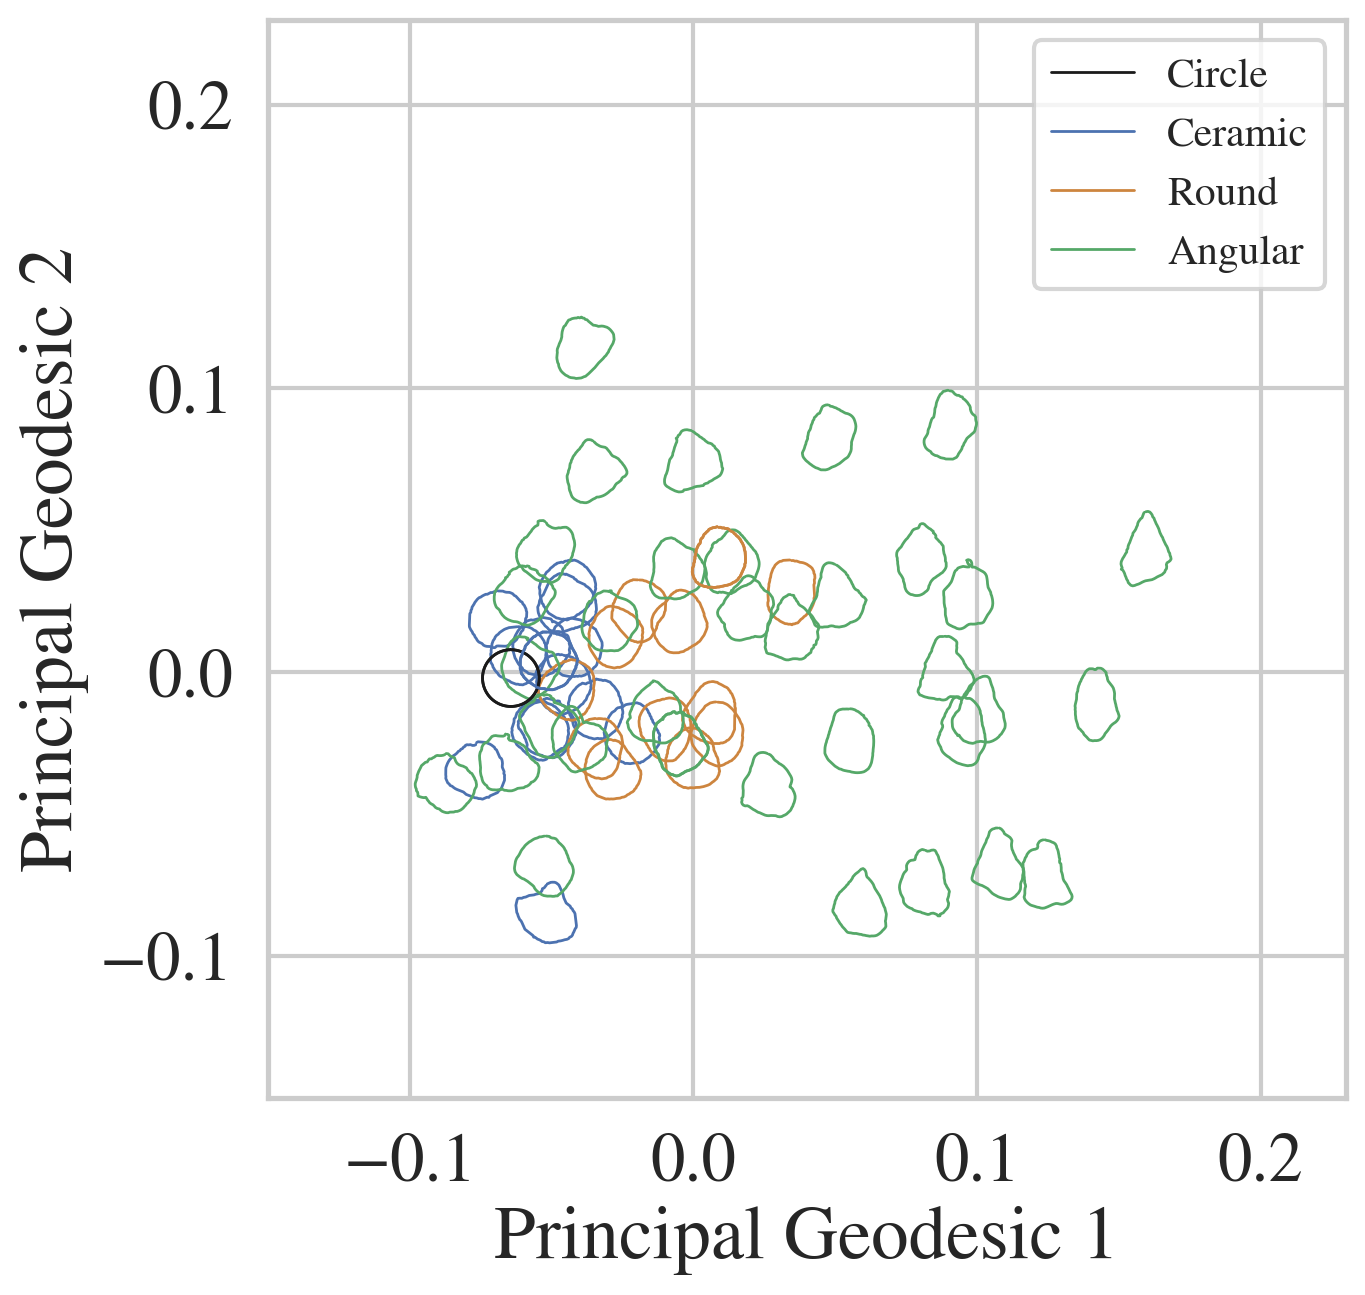

In [32]:
#Plot first two principal components.

%matplotlib inline

plt.figure(dpi = 200)

for i in range(len(curves)):
    
    if labels[i] == 0:
        plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'k',linewidth = 1)
    
    if labels[i] == 1:
        plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'b',linewidth = 1)
        
    elif labels[i] == 2:
        plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'peru',linewidth = 1)
        
    elif labels[i] == 3:
        plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'g',linewidth = 1)
        
    elif labels[i] == 4:
        plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'g',linewidth = 1)

i = 60  
plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'k',label = "Circle",linewidth = 1)
i = 2  
plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'b',label = "Ceramic",linewidth = 1)
i = 18   
plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'peru',label = "Round",linewidth = 1)
i = 40
plt.plot(curves[i][:,0]*.1 + X[i,0],curves[i][:,1]*.1 + X[i,1], c = 'g',label = "Angular",linewidth = 1)


plt.xlim(-.15,.23)
plt.ylim(-.15,.23)

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Principal Geodesic 1")
plt.ylabel("Principal Geodesic 2")

plt.legend(fontsize = 15)

plt.savefig("geo_pca.svg")

# Hypothesis testing

Here we analyze the distance of each particle sample to the perfect cirlce. We see that the ceramic microspheres are closest, followed by the round and angular sand respectively. 

We also perform hypothesis testing to show that there is a statistically significant different in the morphology of the different particle samples. 

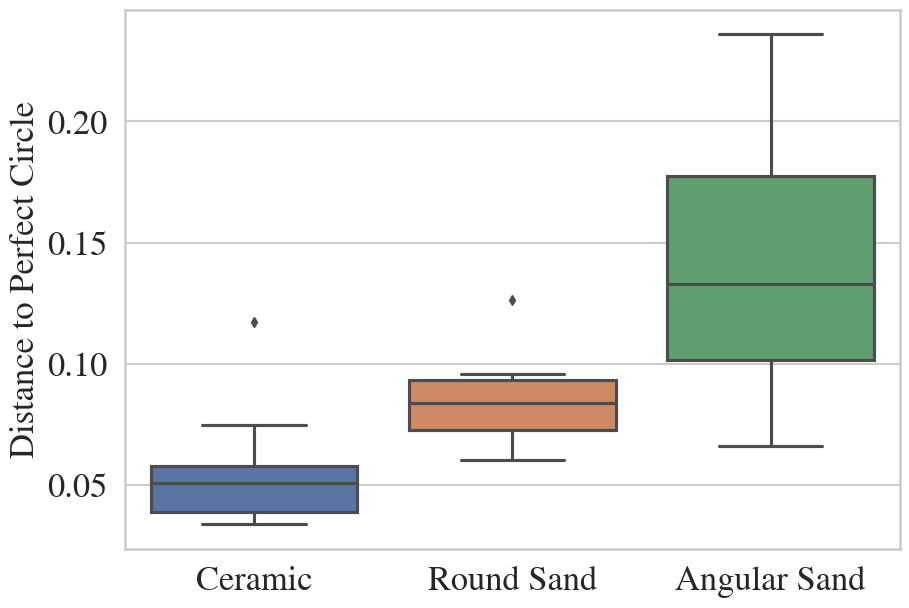

In [33]:
import seaborn as sns

sns.boxplot(x = labels[0:-1], y = np.squeeze(distances)[0:-1])

plt.ylabel("Distance to Perfect Circle", fontsize = 25)

plt.gca().set_xticks([0, 1, 2])

plt.gca().set_xticklabels(['Ceramic', 'Round Sand', 'Angular Sand'])


plt.savefig("hyp_test.eps")

In [34]:
from scipy import stats

groups = []

for i in [1,2,3]:
    groups.append(distances[labels == i])
    
print("P-Value Ceramic Vs. Wisconsin = {}".format(stats.ttest_ind(groups[0], groups[1], equal_var=False)[1]))

print("P-Value Ceramic Vs. Texas = {}".format(stats.ttest_ind(groups[0], groups[2], equal_var=False)[1]))

print("P-Value Wisconsin Vs. Texas = {}".format(stats.ttest_ind(groups[1], groups[2], equal_var=False)[1]))


P-Value Ceramic Vs. Wisconsin = [0.00098313]
P-Value Ceramic Vs. Texas = [7.3975659e-11]
P-Value Wisconsin Vs. Texas = [8.2544037e-07]
